In [ ]:
import os

import pandas as pd
import geopandas as gpd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

import matplotlib.pyplot as plt
import seaborn as sns

import time

In [ ]:
# Check GPU (select GPU L4 in collab)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Pre-treatment

In [ ]:
# Load data from geopackage (we will match the ids with image names)
gpkg_path = '/content/drive/MyDrive/Colab Notebooks/batrem/batrem_4k.gpkg'
layer_name = 'buildings'
gdf = gpd.read_file(gpkg_path, layer=layer_name)

In [ ]:
# Load images and match with tabular data
image_folder = '/content/drive/MyDrive/Colab Notebooks/batrem/image_datasets/4k/'

# Create a DataFrame mapping image filenames to labels
gdf["filename"] = gdf["id"].apply(lambda x: f"{image_folder}{x}.png")

# Image parameters
img_size = (256, 256)  # Resize images to this size

In [ ]:
# Separate features and target and transform in numpy array for futur operations
X = gdf.drop('remarquable', axis=1) # these tabular features wont be used in this CNN experiment
y = gdf['remarquable'] # these labels will be used to speed up metric calculations in the cross validation loop
X = X.to_numpy()
y = y.to_numpy()

In [ ]:
# Function to create an image generator (a tensorflow dataset actually) from specific fold indices
# Each element of the dataset will be a tuple containing an image filename and its label

def create_image_generator(df, indices, batch_size=128, shuffle=False): # no shuffle because we want to match indices
    # Create a tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices((df.iloc[indices]['filename'].values, df.iloc[indices]['remarquable'].values))

    # Preprocessing
    def preprocess_image(image_path, label):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(image, (256, 256))
        image = tf.cast(image, tf.float32) / 255.0
        # Reshape label to 2D (needed to monitor F1 score)
        label = tf.expand_dims(label, axis=-1)  # Add an extra dimension
        return image, label

    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [ ]:
# Define PredefinedSplit using the fold column
predefined_split = PredefinedSplit(gdf['fold'])

In [ ]:
# Check fold balance so we can take their size into account when evaluating data. Fold numbers correspond to spatial areas
for fold_idx, (train_idx, test_idx) in enumerate(predefined_split.split()):
    print(f"Fold {fold_idx + 1}:")
    print(f"Train set: {len(train_idx)} buildings and {np.sum(y[train_idx])} are remarkable")
    print(f"Test set: {len(test_idx)} buildings and {np.sum(y[test_idx])} are remarkable")
    print()

Fold 1:
Train set: 4131 buildings and 1031 are remarkable
Test set: 385 buildings and 98 are remarkable

Fold 2:
Train set: 3335 buildings and 847 are remarkable
Test set: 1181 buildings and 282 are remarkable

Fold 3:
Train set: 4040 buildings and 1054 are remarkable
Test set: 476 buildings and 75 are remarkable

Fold 4:
Train set: 3897 buildings and 940 are remarkable
Test set: 619 buildings and 189 are remarkable

Fold 5:
Train set: 3171 buildings and 752 are remarkable
Test set: 1345 buildings and 377 are remarkable

Fold 6:
Train set: 4006 buildings and 1021 are remarkable
Test set: 510 buildings and 108 are remarkable



## CNN

In [ ]:
def build_cnn(input_shape=(256, 256, 3)):  # Adjust based on your image size
    """
    Builds a CNN model to classify buildings from map images.
    The output is a feature vector that could later be fused with tabular data (in another project).
    """

    # Input layer for images
    inputs = Input(shape=input_shape, name="image_input")

    # Convolutional layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Flatten to 1D vector
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output layer (can be modified for multimodal fusion)
    cnn_output = Dense(64, activation='relu', name="cnn_features")(x)

    # Classification head (optional, removable for multimodal model)
    classification_output = Dense(1, activation='sigmoid', name="cnn_output")(cnn_output)

    # Define model
    model = Model(inputs=inputs, outputs=classification_output, name="CNN_Model")

    # Compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', 'Precision', 'Recall', 'AUC', tf.keras.metrics.F1Score(threshold=0.5, name='f1_score')])

    return model

In [ ]:
# Summary
cnn_model = build_cnn()
cnn_model.summary()

Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cnn_features (Dense)                 │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cnn_output (Dense)                   │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,879,809 (64.39 MB)

 Trainable params: 16,879,361 (64.39 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Store scoring metrics for each fold
scoring = {'acc_train':[], 'acc_test':[],
           'pre_train':[], 'pre_test':[],
           'rec_train':[], 'rec_test':[],
           'f1_train':[], 'f1_test':[],
           'avg_pre_test':[],
           'roc_auc_test':[]
           }

In [ ]:
# Store interpolated curve values for each fold to later plot ROC and PR curves
interp = np.linspace(0, 1, 100) # x-coordinates at which to evaluate the interpolated values
interp_rocs = []
interp_prs = []

In [ ]:
# Store interpolated curve values for each fold to later plot ROC and PR curves
interp = np.linspace(0, 1, 100) # x-coordinates at which to evaluate the interpolated values
interp_rocs = []
interp_prs = []

In [ ]:
# Store true labels and predictions across folds to later produce confusion matrix
y_true_combined = []
y_pred_combined = []

In [ ]:
# Perform cross-validation
start_time = time.time()

# cross-validation
fold_histories = []

for fold_idx, (train_idx, test_idx) in enumerate(predefined_split.split()):
    print(f"Fold {fold_idx + 1}")

     # Create Train & Test Generators (tf datasets) for model fiting
    train_generator = create_image_generator(gdf, train_idx)
    test_generator = create_image_generator(gdf, test_idx)

    # Create the CNN
    model = build_cnn()

    # Define callbacks
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=120, restore_best_weights=False)
    lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                      factor=0.7,
                                                      patience=10)

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=150,
        callbacks=[lr_schedule],
        verbose=1
    )

    fold_histories.append(history)

    # Save model
    model.save('/content/drive/MyDrive/Colab Notebooks/batrem/trained_models/cnn/'+ f'model_CNN_fold_{fold_idx + 1}.keras')

    # Predict on test set
    y_test_proba = model.predict(test_generator).ravel()  # Predicted probabilities to be in the positive class (remarkable)
    y_test_pred = (y_test_proba > 0.5).astype(int)  # Binary predictions

    # Filter labels for evaluation
    y_train, y_test = y[train_idx], y[test_idx]

    # Calculate metrics for this fold on test set and append to lists
    scoring['acc_test'].append(accuracy_score(y_test, y_test_pred))
    scoring['pre_test'].append(precision_score(y_test, y_test_pred))
    scoring['rec_test'].append(recall_score(y_test, y_test_pred))
    scoring['f1_test'].append(f1_score(y_test, y_test_pred))
    scoring['avg_pre_test'].append(average_precision_score(y_test, y_test_pred))

    # Predict on train set
    y_train_proba = model.predict(train_generator).ravel()  # Predicted probabilities to be in the positive class (remarkable)
    y_train_pred = (y_train_proba > 0.5).astype(int)  # Binary predictions

    # Calculate metrics for this fold on train set and append to lists
    scoring['acc_train'].append(accuracy_score(y_train, y_train_pred))
    scoring['pre_train'].append(precision_score(y_train, y_train_pred))
    scoring['rec_train'].append(recall_score(y_train, y_train_pred))
    scoring['f1_train'].append(f1_score(y_train, y_train_pred))

    # Store predictions and true labels to produce confusion matrix
    y_true_combined.extend(y_test)  # Append true labels
    y_pred_combined.extend(y_test_pred)  # Append predicted labels

    ## Compute ROC curve
    scoring['roc_auc_test'].append(roc_auc_score(y_test, y_test_proba)) # store ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_test_proba) # Compute FPR / TPR
    # Interpolate the roc curve (tpr/fpr) to have consistent number of points across folds for later ROC plotting
    interp_roc = np.interp(interp, fpr, tpr)
    interp_rocs.append(interp_roc)

    ## Compute PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
    interp_pr = np.interp(interp, recall[::-1], precision[::-1])  # Reverse to ensure monotonic recall
    interp_prs.append(interp_pr)


end_time = time.time()
training_time = end_time - start_time
print(f"Temps d'entraînement : {training_time / 60:.2f} minutes")

Fold 1
Epoch 1/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 43s 650ms/step - AUC: 0.5771 - Precision: 0.7327 - Recall: 0.8265 - binary_accuracy: 0.7303 - f1_score: 0.7467 - loss: 27.4757 - val_AUC: 0.6552 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_binary_accuracy: 0.7455 - val_f1_score: 0.0000e+00 - val_loss: 2.2957 - learning_rate: 0.0010
Epoch 2/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - AUC: 0.3486 - Precision: 0.4783 - Recall: 0.1878 - binary_accuracy: 0.4148 - f1_score: 0.2473 - loss: 61.4641 - val_AUC: 0.5000 - val_Precision: 0.2545 - val_Recall: 1.0000 - val_binary_accuracy: 0.2545 - val_f1_score: 0.4058 - val_loss: 45.1117 - learning_rate: 0.0010
Epoch 3/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - AUC: 0.3267 - Precision: 0.4726 - Recall: 0.3089 - binary_accuracy: 0.4013 - f1_score: 0.3324 - loss: 60.8327 - val_AUC: 0.5000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_binary_accuracy: 0.7455 - val_f1_score: 0.0000e+00 - val_loss: 24.6835 - learning_rate: 0

## Evaluation

In [ ]:
# Print mean scores
for metric in scoring.keys():
    print(f"Mean {metric}: {np.average(scoring[metric])}")

Mean acc_train: 0.8882298065191235
Mean acc_test: 0.8064798394431617
Mean pre_train: 0.9579686356853779
Mean pre_test: 0.7375807675063616
Mean rec_train: 0.5787607505121427
Mean rec_test: 0.3150972602714209
Mean f1_train: 0.7160240311925029
Mean f1_test: 0.4240624813783133
Mean avg_pre_test: 0.3965516734867789
Mean roc_auc_test: 0.7203812719238769


In [1]:
# Print history keys to verify that each metric as been monitored
print(history.history.keys())

NameError: name 'history' is not defined

In [ ]:
# Create function to plot metrics for each fold during training
def plot_metric(metric, y_max=1):
    plt.figure(figsize=(10, 6))
    plt.ylim(0, y_max)

    max_epochs = max(len(history.history[metric]) for history in fold_histories)  # Get the maximum number of epochs

    for fold_idx, value in enumerate(fold_histories):
        # Pad shorter arrays with NaN to match the longest array
        padded_values = np.pad(value.history[metric], (0, max_epochs - len(value.history[metric])), 'constant', constant_values=np.nan)
        plt.plot(padded_values, alpha=0.4, label=f'Fold {fold_idx + 1}')

    # plot the mean curve (ignoring NaN values)
    all_values = [np.pad(history.history[metric], (0, max_epochs - len(history.history[metric])), 'constant', constant_values=np.nan) for history in fold_histories]
    mean_curve = np.nanmean(all_values, axis=0)  # Use np.nanmean to ignore NaNs
    plt.plot(mean_curve, color='blue', label=f'Mean {metric}', lw=2)

    plt.title(f'CNN {metric.capitalize()} Across Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel(metric.capitalize(), fontsize=14)
    plt.legend(title='Folds', fontsize=12)
    plt.grid(True)
    plt.show()

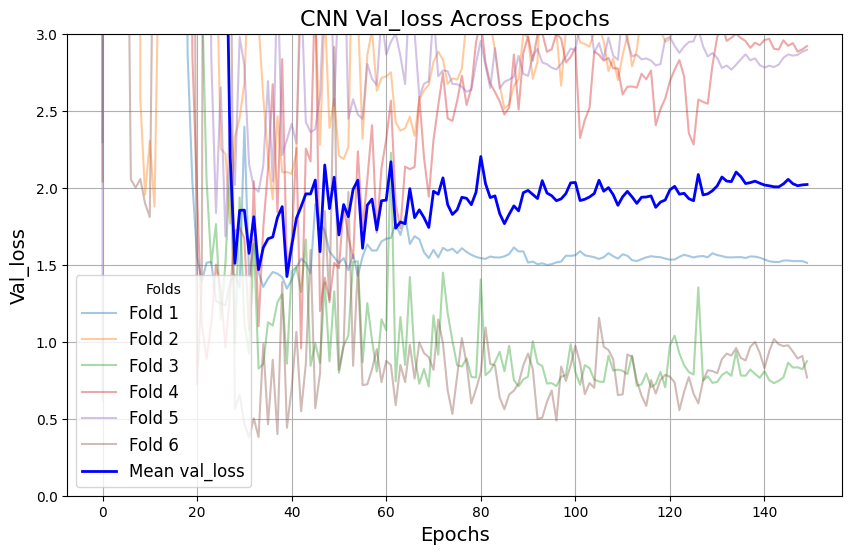

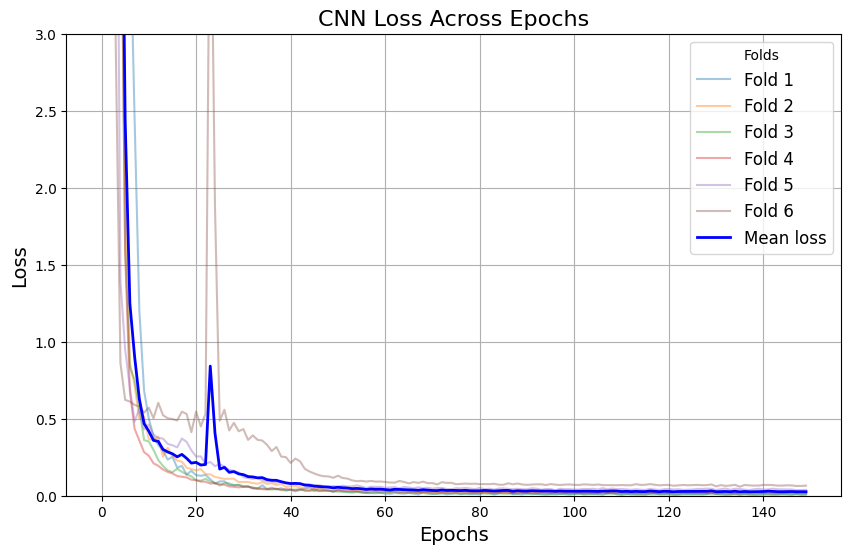

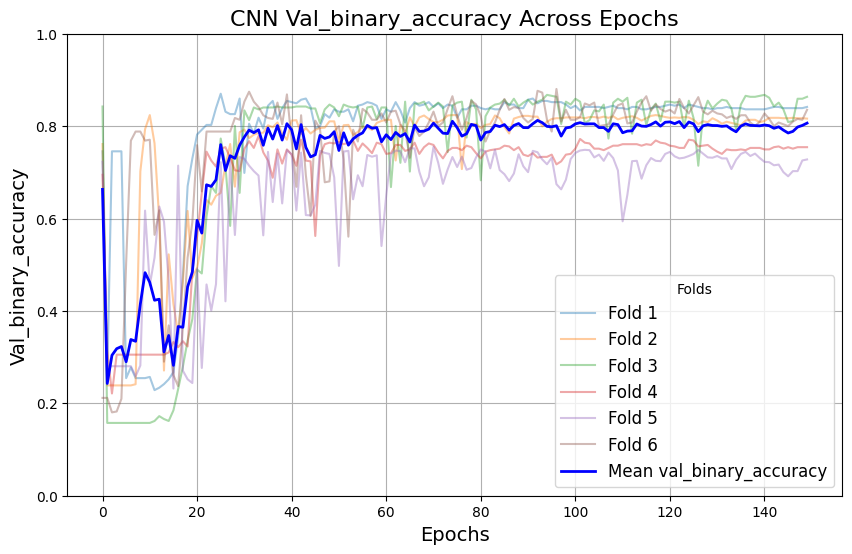

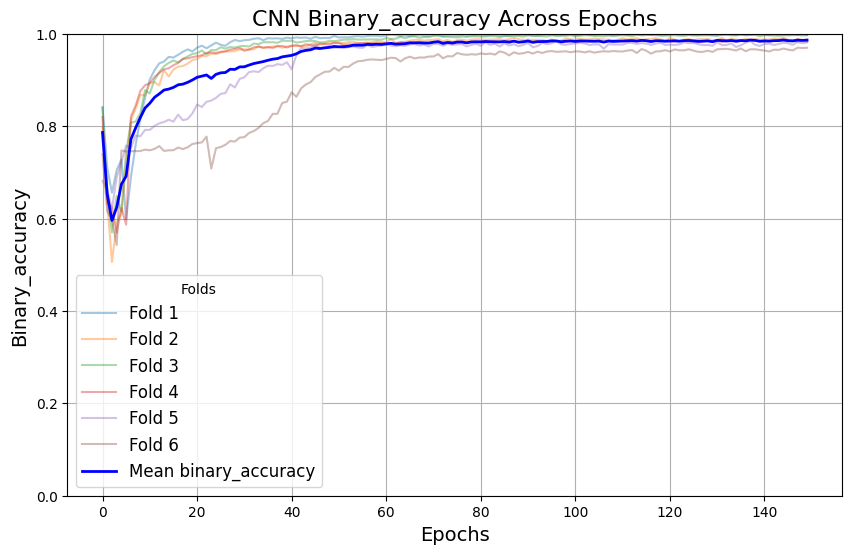

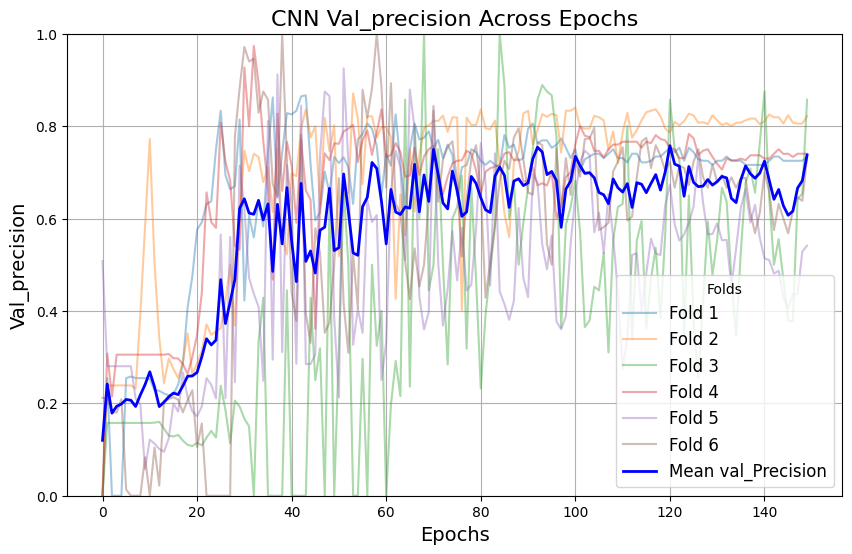

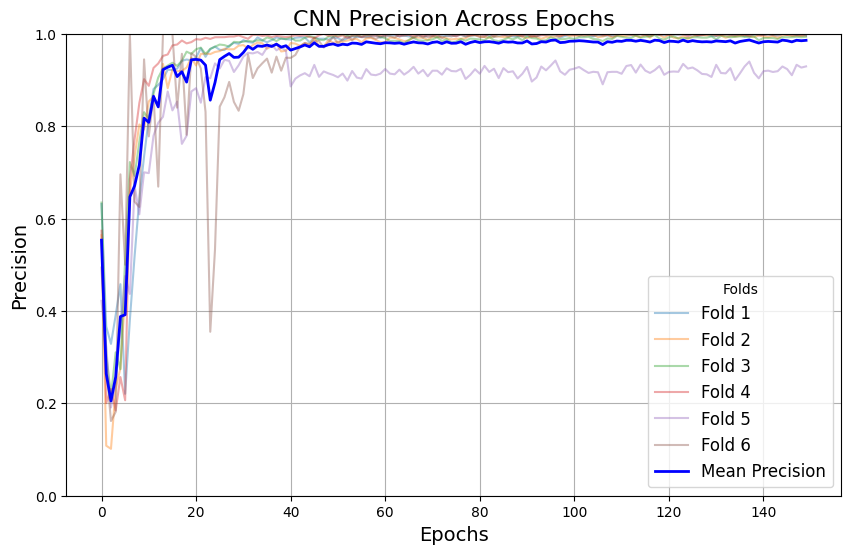

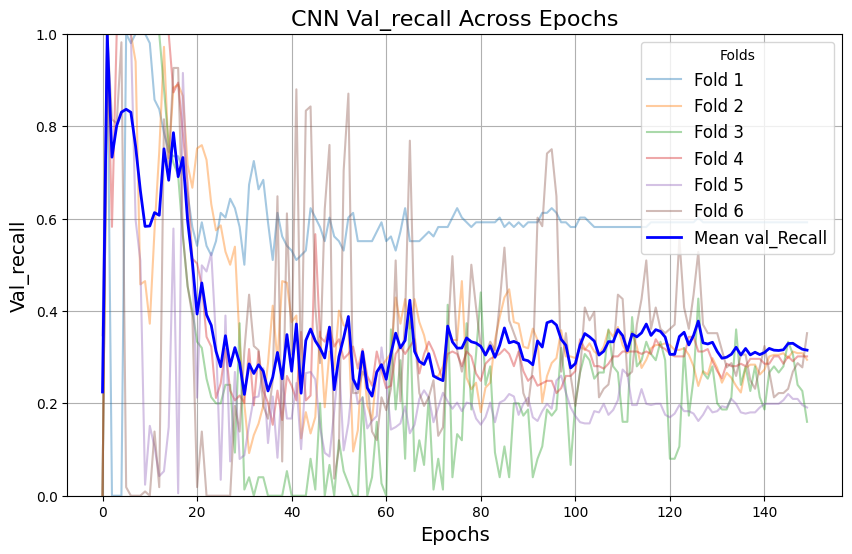

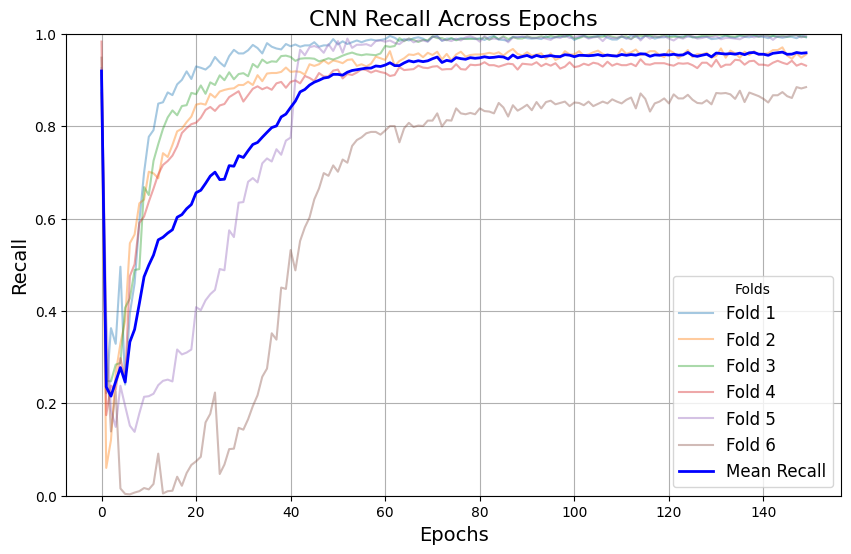

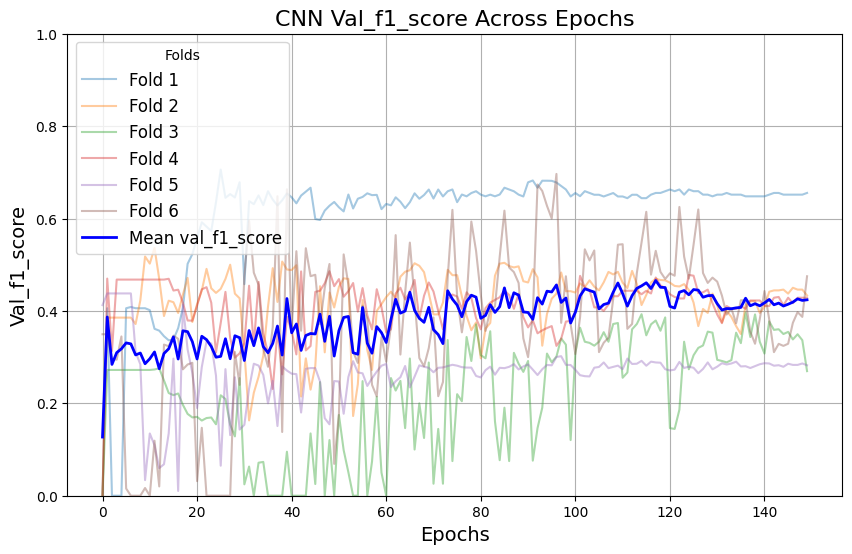

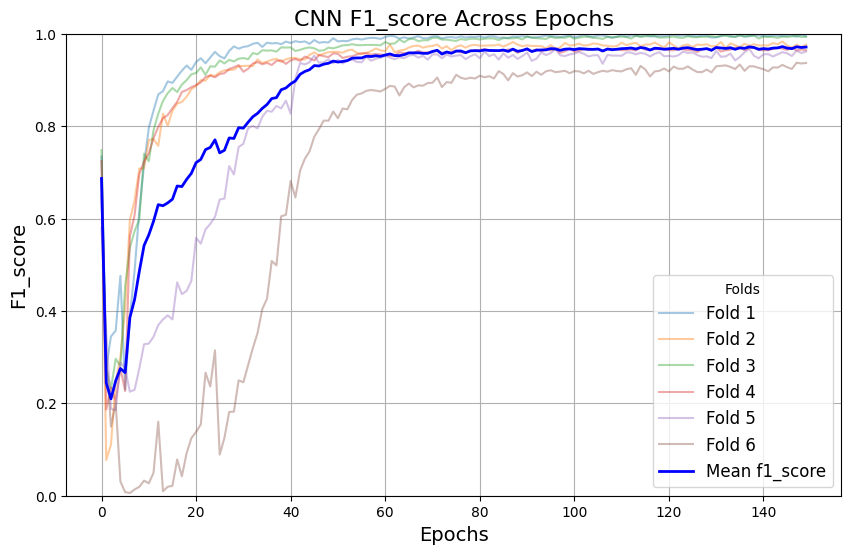

In [ ]:
# plot val loss, train loss, val accuracy, train accuracy, val precision, train precision
plot_metric('val_loss', y_max=3)
plot_metric('loss', y_max=3)
plot_metric('val_binary_accuracy')
plot_metric('binary_accuracy')
plot_metric('val_Precision')
plot_metric('Precision')
plot_metric('val_Recall')
plot_metric('Recall')
plot_metric('val_f1_score')
plot_metric('f1_score')
plot_metric('val_auc')
plot_metric('auc')

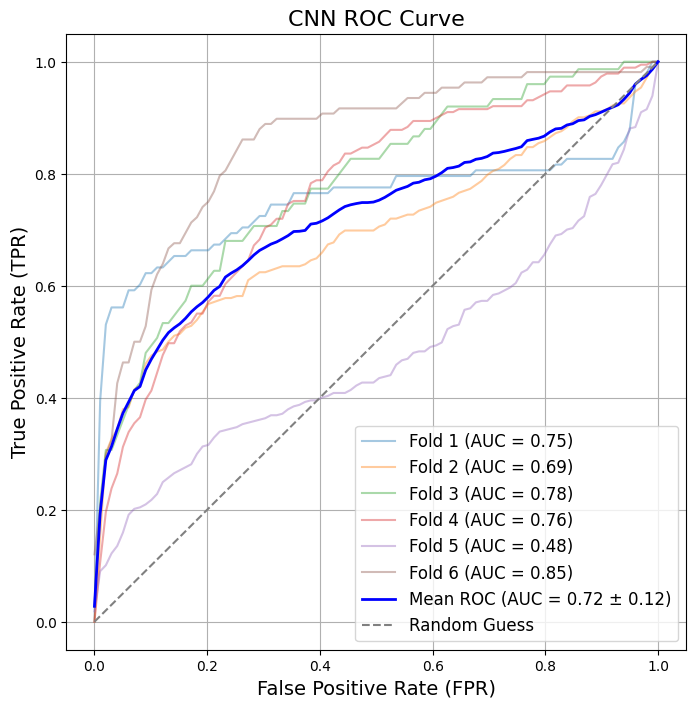

In [ ]:
### Plot ROC curve
plt.figure(figsize=(8, 8))

# Plot individual fold ROC curves
for i, (interp_roc, auc) in enumerate(zip(interp_rocs, scoring['roc_auc_test'])):
    plt.plot(interp, interp_roc, alpha=0.4, label=f'Fold {i+1} (AUC = {auc:.2f})')

# Compute and plot the mean ROC curve and its AUC
mean_roc = np.mean(interp_rocs, axis=0)
mean_roc[-1] = 1.0  # Ensure the curve ends at (1, 1)
mean_auc = np.mean(scoring['roc_auc_test'])
std_auc = np.std(scoring['roc_auc_test'])
plt.plot(np.linspace(0, 1, 100), mean_roc, color='blue', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')

# Finalize the plot
plt.title('CNN ROC Curve', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

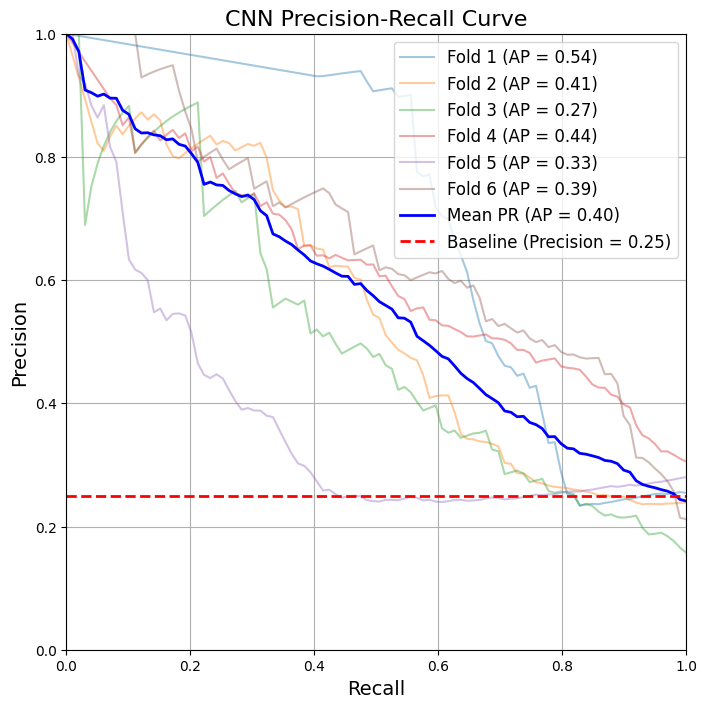

In [ ]:
### Plot the PR curve
plt.figure(figsize=(8, 8))

# Force to display x and y from 0 to 1
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# Plot individual fold PR curves
for i, interp_pr in enumerate(interp_prs):
    plt.plot(interp, interp_pr, alpha=0.4, label=f'Fold {i+1} (AP = {scoring["avg_pre_test"][i]:.2f})')

# Compute and plot the  mean PR curve
mean_pr = np.mean(interp_prs, axis=0)
mean_avg_precision = np.mean(scoring["avg_pre_test"])
plt.plot(np.linspace(0, 1, 100), mean_pr, color='blue', label=f'Mean PR (AP = {mean_avg_precision:.2f})', lw=2)

# Add the baseline
baseline_precision = 0.25
plt.axhline(y=baseline_precision, color='red', linestyle='--', label=f'Baseline (Precision = {baseline_precision:.2f})', lw=2)

# Finalize the plot
plt.title('CNN Precision-Recall Curve', fontsize=16)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.96      0.87      3387
           1       0.70      0.28      0.40      1129

    accuracy                           0.79      4516
   macro avg       0.75      0.62      0.64      4516
weighted avg       0.78      0.79      0.76      4516



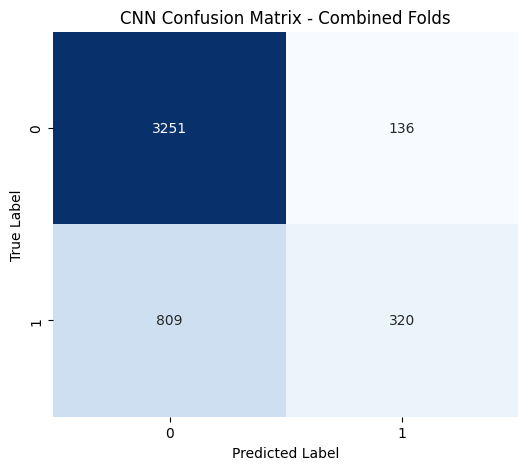

In [ ]:
## Confusion Matrix

# Convert lists to numpy arrays
y_true_combined = np.array(y_true_combined)
y_pred_combined = np.array(y_pred_combined)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_combined, y_pred_combined)

# Print classification report
print("Classification Report:\n", classification_report(y_true_combined, y_pred_combined))

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1], cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("CNN Confusion Matrix - Combined Folds")
plt.show()